# Train a video embedding model

A "video embedding model" is a function that represents video clips as points in a high-dimensional space. These embeddings can then be used for downstream tasks such as clustering or supervised behavior classification. This tutorial includes the following steps:

1. [Optional] crop videos around the subject of interest
2. Set up data loading and augmentation
3. Fit the embedding model using [Barlow Twins](https://arxiv.org/abs/2103.03230)
4. Inspect embeddings for a random sample of video clips

This tutorial uses an [example dataset](https://www.dropbox.com/scl/fo/habb4oa7pgms012amnynu/AFTDSfk-x6wgNI0fbSjJIwc?rlkey=g06de47y5kpu6ds5sxqwwpfr7&dl=0) with 4 videos of mice engaged in nest-building.


In [2]:
import video_embedding as ve
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from torch.utils.data import DataLoader
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import os

## 1. [Optional] crop videos around the subject of interest

We recommend cropping videos around the subject animal to speed up training and highlight relevant aspects of the video. 
- For multianimal videos, we recommend cropping around one animal or limiting the input data to times when the animals are close together.
- This step requires tracking the animal(s) in each video. For now, users must supply their own tracking data. A separate tracking tutorial is in development. 

### Load tracking data

In the example dataset, each video is paired with a `*.track.npy` file containing the mouse's centroid at each timepoint. 
```
    example_data
    ├──video1.mp4
    ├──video1.track.npy
    ├──video2.mp4
    ├──video2.track.npy
    ⋮
```
These files are loaded into a dictionary that maps video paths to tracks. **Note: although the pipeline does not require any specific file organization, a dictionary with this format is required for the next set of steps.**

In [3]:
# List paths to example videos (adjust as necessary)
video_paths = [f"example_data/video{i}.mp4" for i in range(1,5)]

# Load centroids
tracks = {}
for video_path in video_paths:
    track_path = video_path.replace(".mp4", ".track.npy")
    tracks[video_path] = np.load(track_path)

### Choose a crop size
Two rounds a cropping are performed during model training. First, videos are preprocessed using an "outer crop size", which helps speed up video-reading operations. Video clips are then cropped a second time using an "inner crop size" before being fed to the model. The outer crop size should be 1.3 - 1.5 times bigger than the inner crop size to so that clips can be translated and rotated during model training without significant border artifacts. The code below shows what the selected crop sizes look like in a random sample of frames. Adjust as necessary for your own data. **Note: the outer crop size should be divisible by 16 to prevent resizing during video encoding**.

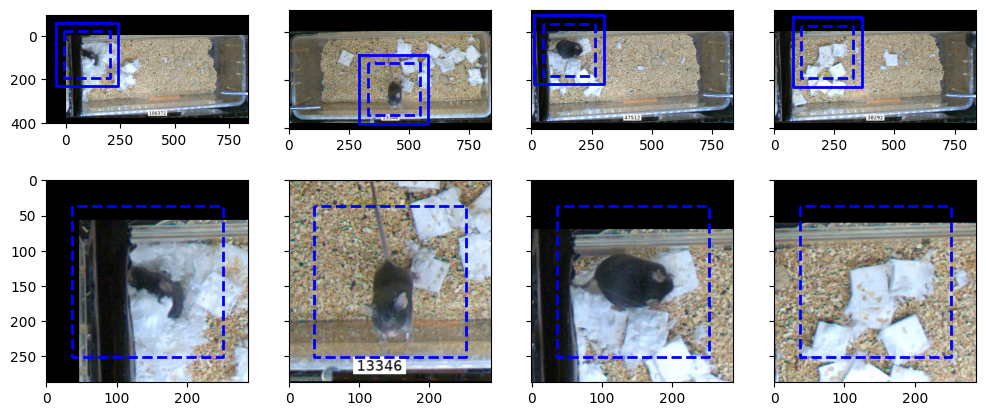

In [4]:
outer_crop_size = 288 # this is used for preprocesing the videos
inner_crop_size = 216 # this is the final size that will be used for video embedding (can be changed later)

fig = ve.inspect_crop_sizes(tracks, inner_crop_size, outer_crop_size)
fig.set_size_inches((12,5.5))
fig.subplots_adjust(hspace=0)

### Smooth tracking data
To avoid jitter and/or outlier frames, it's important to smooth the tracking data. In the code below, a median filter is used to remove outliers and then a Gaussian filter is used for overall smoothing.


In [13]:
median_kernel_size = 61  # corresponds to ~2 seconds for the example data
gaussian_kernel_size = 15 # corresponds to 0.5 seconds for the example data

smooth_tracks = {}
for video_path, track in tracks.items():
    track = median_filter(track, (median_kernel_size, 1))
    track = gaussian_filter1d(track, gaussian_kernel_size, axis=0)
    smooth_tracks[video_path] = track

### Crop videos

Cropped videos are saved alongside the original videos with `*.cropped.mp4` appended to the name, e.g.
```
    example_data
    ├──video1.cropped.mp4
    ├──video2.cropped.mp4
    ⋮
```

In [14]:
for video_path, track in smooth_tracks.items():
    cropped_video_path = video_path.replace(".mp4", ".cropped.mp4")
    print(f'saving "{cropped_video_path}"')
    ve.crop_video(video_path, cropped_video_path, track, outer_crop_size)

saving "example_data/video1.cropped.mp4"


100%|████████████████████████████████████████████████████████████████████████████| 108002/108002 [5:02:18<00:00,  5.95it/s]


saving "example_data/video2.cropped.mp4"


100%|█████████████████████████████████████████████████████████████████████████████| 108002/108002 [02:21<00:00, 764.35it/s]


saving "example_data/video3.cropped.mp4"


100%|████████████████████████████████████████████████████████████████████████████| 108002/108002 [2:19:35<00:00, 12.90it/s]


saving "example_data/video4.cropped.mp4"


100%|████████████████████████████████████████████████████████████████████████████| 108002/108002 [1:27:51<00:00, 20.49it/s]


## 2. Set up data loading and augmentation

The goal of training is to teach the embedding model to focus on the semantically-meaningful content of video clips while ignoring superficial features such as lighting, location, angle, etc. To accomplish this, clips are randomly sampeled from the dataset, distorted/augmented in two different ways, and then fed to the embedding model. During training, the model learns to embed each pair of distorted clips in a similar location. 

### Augmentations
- **Basic image augmentation:** Changes in brightness, contrast, color, blur, scale, and orientation
- **Random cropping:** Source clips (whose initial dimension is `outer_crop_size`) are cropped around two different (drifting) centroid locations to a final size of `inner_crop_size`
- **Random trimming** Source clips (whose initial duration is `outer_clip_duration`) are trimmed to a pair of randomly-offset intervals with a final duration of `inner_clip_duration`)

### Downsampling
It is important to avoid small batch sizes during model training. The smallest we have tested is 16. To avoid out-of-memory errors, users may need to shrink the size and/or duration of clips that are fed to the model. This can be done using the `temporal_downsample` and `spatial_downsample` parameters. Each batch of clips will have a final shape of `[batch_size, duration, 3, height, width]` where 
- `duration = inner_clip_duration / temporal_downsample`
- `height = inner_crop_size / spatial_downsample`
- `width = inner_crop_size / spatial_downsample`

In [2]:
outer_clip_duration = 90 # loader will sample 3 second clips from videos (fps=30)
inner_clip_duration = 60 # augmentator will trim using a random pair of 2-second windows
temporal_downsample = 2 # 2-second clips will be downsampled to a final duration of 30 frames

inner_crop_size = 216 # (this is defined with respect to the original non-downsampled video)
spatial_downsample = 1 # no resizing - final clips will be 216x216

batch_size = 16 # requires about 40GB of GPU memory using the parameters above
num_workers = 8 # make sure this is less than the number of available CPU cores

# adjust path as necessary
video_paths = [f"example_data/video{i}.cropped.mp4" for i in range(1,5)]

# create augmentator (see docstring for additional parameters)
augmentator = ve.VideoClipAugmentator(
    duration = inner_clip_duration // temporal_downsample, 
    crop_size = inner_crop_size // spatial_downsample,
)

# intantiate dataset (class for loading clips and applying augmentations)
dataset = ve.VideoClipDataset(
    video_paths,
    augmentator, 
    outer_clip_duration, 
    temporal_downsample,
    spatial_downsample
)

# wrap dataset in DataLoader class that handles parallelization
dataloader = DataLoader(
    dataset, 
    shuffle=True, 
    batch_size=batch_size, 
    num_workers=num_workers,
    pin_memory=True
)

### Visualize augmentations
The following code samples one batch of augmented clip-pairs from the data loader, and then renders each pair in a separate column.

In [3]:
ve.inspect_dataloader(dataloader, num_samples=4)

## 3. Fit the embedding model using [Barlow Twins](https://arxiv.org/abs/2103.03230)

The code below instantiates an embedding model (also referred to as a "backbone") and then trains it using a Barlow Twins objective. In principle, any neural network that maps videos to feature vectors can serve as an embedding model. Currently we only support the [S3D backbone](https://docs.pytorch.org/vision/main/models/video_s3d.html) from torchvision, but other networks (such as vision transformers) may also perform well. 

In [3]:
# instantiate embedding model (currently s3d is the only supported model type)
embedding_model, feature_size = ve.get_embedding_model("s3d")

# setup training objective, optimizer and scheduler
device = "cuda" if torch.cuda.is_available() else "cpu"
learner = ve.BarlowTwins(embedding_model, feature_size).to(device).train()
optimizer = torch.optim.Adam(learner.parameters(), lr=1e-3) # adjust initial learning rate as necessary
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

### Training loop

The following code creates checkpoint directory and then trains for a specified number of epochs. *Note that the number of epochs and the number of steps-per-epoch are fungible; lowering one and raising the other simply shifts the checkpoint frequency.*

**To resume a previous training run**, set `checkpoint_dir` to the previous run's checkpoint directory. Training will resume from the most recent checkpoint.




In [4]:
num_epochs = 500
steps_per_epoch = 2000

# specificy a directory for storing model checkpoints and losses
# (override as needed, e.g. when resuming a previous training run)
training_run_name = str(datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
checkpoint_dir = os.path.join(training_run_name, "checkpoints")

ve.train(
    learner,
    optimizer,
    scheduler,
    dataloader,
    num_epochs,
    steps_per_epoch,
    checkpoint_dir,
    device,
)

Epoch 10/10: 100%|████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.01s/batch, loss=1.05e+3]


### Plot training loss

Training should ideally continue until the training loss levels off. *(There is no separate validation loss because the objective is self-supervised)*

In [ ]:
loss_log = pd.read_csv(os.path.join(checkpoint_dir, "loss_log.csv"))
plt.plot(loss_log["epoch"], loss_log["loss"])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.gcf().set_size_inches((3,2))

## 4. Inspect embeddings for a random sample of video clips

In [7]:
# adjust path as necessary
video_paths = [f"example_data/video{i}.cropped.mp4" for i in range(1,5)]

In [9]:
paths = []
starts = []
embeddings = []

In [11]:
paths = []
starts = []
embeddings = []

for i in tqdm.trange(500):
    ix = np.random.choice(len(video_paths))
    path = video_paths[ix]
    start = np.random.randint(lengths[ix]-60)
    clip = ve.get_clip(path, start, duration=60)[::2]
    clip = ve.center_crop(clip, image_size)
    X = ve.transform_video(clip)[None]
    embedding = model(X.to(device))
    embeddings.append(embedding.detach().cpu().numpy()[0])
    starts.append(start)
    paths.append(path)

embeddings = np.array(embeddings)
joblib.dump((paths, starts, embeddings), 'videoclips.p')


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [16:12<00:00,  1.95s/it]


['videoclips.p']

In [12]:
Xpca = PCA(n_components=20).fit_transform(embeddings)
xy = UMAP(n_components=2, n_neighbors=50).fit_transform(Xpca)

C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


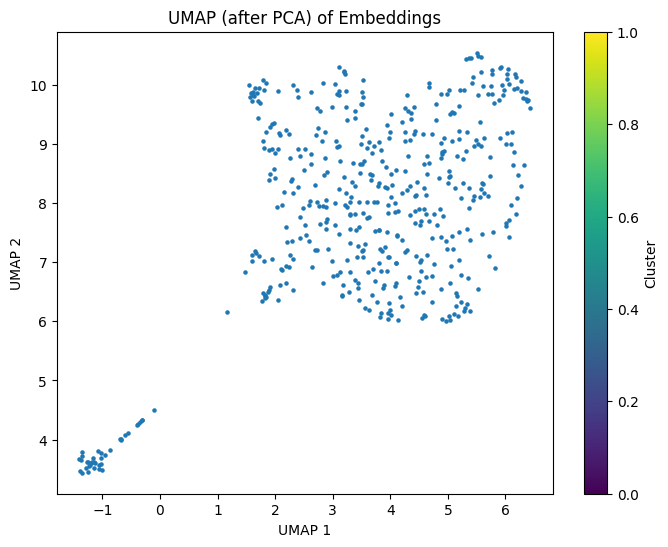

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(xy[:, 0], xy[:, 1], s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP (after PCA) of Embeddings')
plt.colorbar(label='Cluster')
plt.show()


In [14]:
n_clusters = 8
clus = KMeans(n_clusters=n_clusters).fit_predict(Xpca)

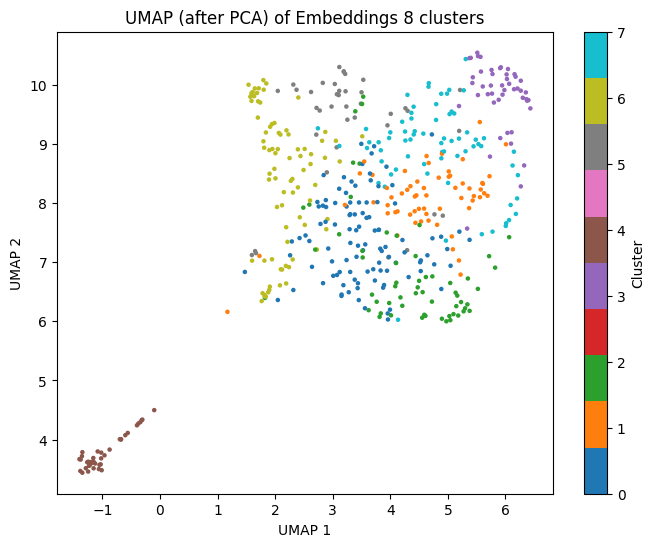

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(xy[:, 0], xy[:, 1], c=clus, cmap='tab10', s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP (after PCA) of Embeddings 8 clusters')
plt.colorbar(label='Cluster')
plt.show()


In [17]:
n_clusters = 16
clus = KMeans(n_clusters=n_clusters).fit_predict(Xpca)

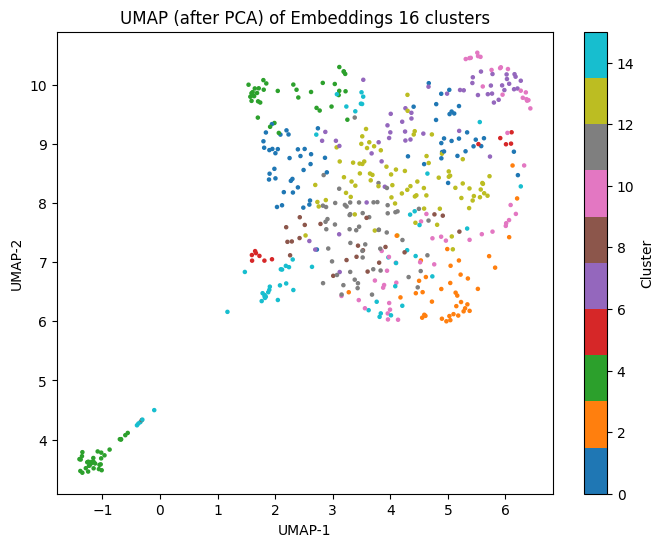

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(xy[:,0], xy[:,1], c=clus, cmap='tab10', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title('UMAP (after PCA) of Embeddings 16 clusters')
plt.show()

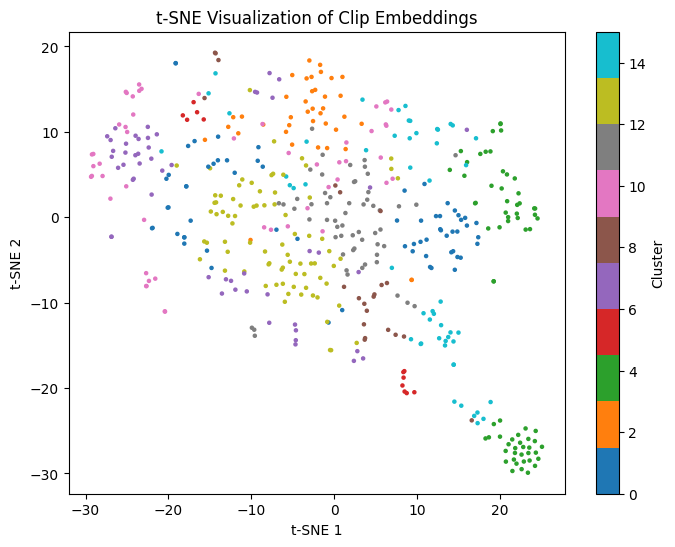

In [19]:
xy_tsne = TSNE(n_components=2, random_state=0, perplexity=30).fit_transform(Xpca)

plt.figure(figsize=(8,6))
plt.scatter(xy_tsne[:,0], xy_tsne[:,1], c=clus, cmap='tab10', s=5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization of Clip Embeddings')
plt.colorbar(label='Cluster')
plt.show()

### 3.3 Interactive 3D PCA

In [29]:
xy = UMAP(n_components=3, n_neighbors=50).fit_transform(Xpca)


C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [39]:
fig = px.scatter_3d(
    x=xy[:, 0], y=xy[:, 1], z=xy[:, 2],
    color=clus,  
    labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'z': 'UMAP 3'},
    title='Interactive 3D UMAP (after PCA) of Embeddings',
    opacity=0.7
)
fig.update_traces(marker=dict(size=3)) 
pio.show(fig)
fig.write_html("Interactive 3D UMAP (after PCA) of Embeddings.html")

### 3.4 NMF

In [56]:
n_components = 8  
nmf = NMF(n_components=n_components, random_state=0)
W = nmf.fit_transform(embeddings)  
H = nmf.components_                 

C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


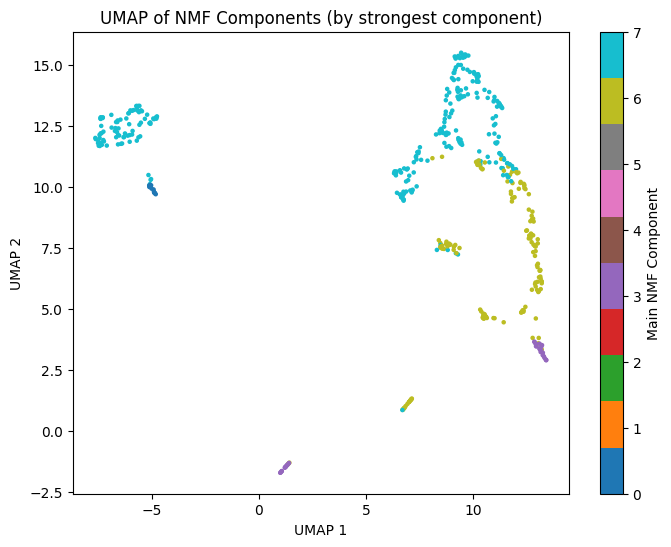

In [57]:
xy_nmf = UMAP(n_components=2, random_state=0).fit_transform(W)

plt.figure(figsize=(8,6))
plt.scatter(xy_nmf[:,0], xy_nmf[:,1], c=W.argmax(axis=1), cmap='tab10', s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of NMF Components (by strongest component)')
plt.colorbar(label='Main NMF Component')
plt.show()